# SVM SMO 

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [174]:
# versi shandy, banyak bug nya wkwkwk

class SVC():
    
    def __init__(self,
                 C = 1.0,
                 max_passes = 10,
                 tol = 1e-5):
        
        self.C = C
        self.max_passes = max_passes
        self.tol = tol
        
    def _init_params(self, X):
        n_samples = X.shape[0]
        self.alpha = np.zeros(n_samples)
        self.b = 0
        
    def _calculate_w(self, X, y):
        w = np.dot(X.T, self.alpha * y)
        return w
        
    def _calculate_F(self, X_star, X, y):
        """using Eq.(2)"""
        f_x = np.dot(self.alpha*y, np.dot(X, X_star.T)) + self.b
        
        return f_x
    
    def _calculate_E(self, X_star, y_star, X, y):
        """using Eq.(13)"""
        # calculate f(x)
        f_x = self._calculate_F(X_star, X, y)

        E_i = f_x - y_star

        return E_i
    
    def _generate_j(self, n, idx):
        """random sample dimana j!=idx"""
        j = np.random.choice(n)
        
        while j == idx:
            j = np.random.choice(n)
            
        return j
    
    def _calculate_boundaries(self, y_i, y_j, a_i, a_j):
        """
        obtain the lower & upper boundary
        using Eq. (10) & (11)
        """
        if y_i != y_j:
            L = max(0, a_j - a_i)
            H = min(self.C, self.C + a_j - a_i)

        else:
            L = max(0, a_i + a_j - self.C)
            H = min(self.C, a_i + a_j)

        return L, H
    
    def _calculate_eta(self, X_i, X_j):
        """using Eq.(14)"""
        eta = 2 * (np.dot(X_i, X_j)) \
        - (np.dot(X_i, X_i)) - (np.dot(X_j, X_j))

        return eta
    
    def fit(self, X, y):
        
        X = np.array(X)
        y = np.array(y)
        n_samples = X.shape[0]
        
        self._init_params(X)
        passes = 0

        while (passes < self.max_passes):
            num_changed_alphas = 0

            for i in range(n_samples):
                # extract data index i

                X_i = X[i].copy()
                y_i = y[i].copy()
                a_i = self.alpha[i].copy()

                # hitung E_i menggunakan persamaan (2)
                E_i = self._calculate_E(X_star = X_i,
                                        y_star = y_i,
                                        X = X,
                                        y = y)

                cond_1 = (y_i*E_i < -self.tol).all() and (a_i < self.C).all()
                cond_2 = (y_i*E_i > self.tol).all() and (a_i > 0).all()
                
                if cond_1 or cond_2:
                    # pilih j secara random
                    j = self._generate_j(n_samples, i)

                    # extract data index j
                    X_j = X[j].copy()
                    y_j = y[j].copy()
                    a_j = self.alpha[j].copy()

                    # hitung E_j menggunaan persamaan (2)
                    E_j = self._calculate_E(X_star = X_j,
                                            y_star = y_j,
                                            X = X,
                                            y = y)

                    # update alpha values
                    a_i_old, a_j_old = a_i, a_j

                    # hitung L dan H (upper and lower bound) menggunakan persamaan (10) dan (11)
                    L, H = self._calculate_boundaries(y_i = y_i,
                                                      y_j = y_j,
                                                      a_i = a_i,
                                                      a_j = a_j)

                    # check boundaries condition
                    if L == H:
                        continue

                    # calculate eta menggunakan persamaan (14)
                    eta = self._calculate_eta(X_i = X_i,
                                              X_j = X_j)

                    # check eta condition
                    if eta >= 0:
                        continue

                    # hitung dan clip new value dari a_j menggunakan (12) dan (15)
                    a_j_unclipped = a_j_old - (y_j * (E_i - E_j)) / eta

                    # condition to clip new value a_j
                    if a_j_unclipped.all() > H:
                        a_j_new = H

                    elif L <= a_j_unclipped.all() and a_j_unclipped.all() <= H:
                        a_j_new = a_j_unclipped
                        
                    else:
                        a_j_new = L

                    # cek kondisi nilai a_j dengan tol
                    if np.abs(a_j_new - a_j_old).all() < tol:
                        continue

                    # determine value a_i menggunakan persamaan (16)
                    a_i_new = a_i_old + y_i * y_j * (a_j_old - a_j)

                    # compute b1 dan b2 menggunakan persamaan (17) dan (18)
                    b1 = b - E_i \
                         - y_i * (a_i_new - a_i_old) * np.dot(X_i, X_i) \
                         - y_j * (a_j_new - a_j_old) * np.dot(X_i, X_j)

                    b2 = b - E_j \
                         - y_i * (a_i_new - a_i_old) * np.dot(X_i, X_j) \
                         - y_j * (a_j_new - a_j_old) * np.dot(X_j, X_j)

                    # compute b menggunakan persamaan (19)
                    if 0 < a_i.all() and a_i.all() < self.C:
                        b_new = b1

                    elif 0 < a_j.all() and a_j.all() < self.C:
                        b_new = b2

                    else:
                        b_new = (b1 + b2) / 2
                        
                    print(self.alpha[i])
                    print(self.alpha[j])

                    self.alpha[i] = a_i_new
                    self.alpha[j] = a_j_new
                    self.b = b_new

                    num_changed_alphas += 1

            if num_changed_alphas == 0:
                passes += 1

            else:
                passes = 0

        
    def predict(self, X):
        y_pred = np.dot(X, self.w) + b

        
        return np.sign((y_pred > 0).astype(int))

In [175]:
obj = SVC()

In [176]:
obj.fit(X, y)

0.0
0.0
0.0
0.0


ValueError: setting an array element with a sequence.

In [123]:
for i in range(len(X)):
    j = np.random.choice(len(X))
    
    if j == i:
        print(f"lah kok sama {j} and {i}")

In [124]:
c = []
for i in range(len(X)):
    a = obj._generate_j(len(X), i)
    c.append(a)

In [125]:
c

[1, 2, 1, 1]

In [55]:
def calculate_F(X_star, X, y, alpha, b):
    w = calculate_w(alpha, X, y)
    
    f_x = np.dot(X_star, w) + b
    
    return f_x
    
    
    
#     result = []
#     n_samples = X.shape[0]
    
#     for i in range(n_samples):
#         E = alpha[i] * y[i] * np.dot(X[i], X_star)
#         result.append(E)
        
#     f_x = np.sum(result) + b
    
#     return f_x

In [56]:
def calculate_E(X_star, y_star, X, y, alpha, b):
    # calculate f(x)
    f_x = calculate_F(X_star, X, y, alpha, b)
    
    E_i = f_x - y_star
    
    return E_i

In [57]:
def generate_j(n_samples, i_idx):
    
    j = np.random.choice(n_samples)
    
    if j != i_idx:
        return j
    
    else:
        generate_j(n_samples, i_idx)

In [58]:
def calculate_boundaries(y_i, y_j, a_i, a_j, C):
    
    if y_i != y_j:
        L = max(0, a_j - a_i)
        H = min(C, C + a_j - a_i)
        
    else:
        L = max(0, a_i + a_j - C)
        H = min(C, a_i + a_j)
        
    return L, H

In [59]:
def calculate_eta(X_i, X_j):
    eta = 2 * (np.dot(X_i, X_j)) \
    - (np.dot(X_i, X_i)) - (np.dot(X_j, X_j))
    
    return eta

In [60]:
def fit(X, y, max_passes, C, tol):
    
    n_samples = X.shape[0]
    alpha = np.zeros(n_samples)
    b = 0
    passes = 0
    
    while passes < max_passes:
        num_changed_alphas = 0

        for i in range(n_samples):
            # extract data index i

            X_i = X[i].copy()
            y_i = y[i].copy()
            a_i = alpha[i].copy()

            # hitung E_i menggunakan persamaan (2)
            E_i = calculate_E(X_star = X_i,
                              y_star = y_i,
                              X = X,
                              y = y,
                              alpha = alpha,
                              b = b)

            cond_1 = ((y_i * E_i) < -tol) and (a_i < C)
            cond_2 = ((y_i * E_i) > tol) and (a_i > 0)

            if cond_1 or cond_2:
                # pilih j secara random
                j = generate_j(n_samples = n_samples,
                               i_idx = i)

                # extract data index j
                X_j = X[j].copy()
                y_j = y[j].copy()
                a_j = alpha[j].copy()

                # hitung E_j menggunaan persamaan (2)
                E_j = calculate_E(X_star = X_j,
                                  y_star = y_j,
                                  X = X,
                                  y = y,
                                  alpha = alpha,
                                  b = b)

                # update alpha values
                a_i_old = a_i
                a_j_old = a_j
                
                print(y_i)
                print(y_j)

                # hitung L dan H (upper and lower bound) menggunakan persamaan (10) dan (11)
                L, H = calculate_boundaries(y_i = y_i,
                                            y_j = y_j,
                                            a_i = a_i,
                                            a_j = a_j,
                                            C = C)

                # check boundaries condition
                if L == H:
                    continue

                # calculate eta menggunakan persamaan (14)
                eta = calculate_eta(X_i = X_i,
                                    X_j = X_j)

                # check eta condition
                if eta >= 0:
                    continue

                # hitung dan clip new value dari a_j menggunakan (12) dan (15)
                a_j -= (y_j * (E_i - E_j)) / eta

                # condition to clip new value a_j
                if a_j > H:
                    a_j = H

                elif L <= a_j and a_j <= H:
                    a_j = a_j

                else:
                    a_j = L

                # cek kondisi nilai a_j dengan tol
                if np.abs(a_j - a_j_old) < tol:
                    continue

                # determine value a_i menggunakan persamaan (16)
                a_i += y_i * y_j * (a_j_old - a_j)

                # compute b1 dan b2 menggunakan persamaan (17) dan (18)
                b1 = b - E_i \
                     - y_i * (a_i - a_i_old) * np.dot(X_i, X_i) \
                     - y_j * (a_j - a_j_old) * np.dot(X_i, X_j)

                b2 = b - E_j \
                     - y_i * (a_i - a_i_old) * np.dot(X_i, X_j) \
                     - y_j * (a_j - a_j_old) * np.dot(X_j, X_j)

                # compute b menggunakan persamaan (19)
                if 0 < a_i and a_i < C:
                    b = b1

                elif 0 < a_j and a_j < C:
                    b = b2

                else:
                    b = (b1 + b2) / 2

                alpha[i] = a_i
                alpha[j] = a_j

                num_changed_alphas += 1

        if num_changed_alphas == 0:
            passes += 1

        else:
            passes = 0
            
    return alpha, b

In [61]:
def calculate_w(alpha, X, y):
    w = np.dot(X.T, alpha * y)
    
    return w

In [62]:
def predict(X, w, b):
    y_pred = np.dot(X, w) + b
    
    return np.sign((y_pred > 0).astype(int))

In [63]:
data_dict = {
    "x1": [0, 0, 1, 1],
    "x2": [0, 1, 0, 1],
    "y": [-1, 1, 1, 1]
}

In [64]:
data = pd.DataFrame(data = data_dict)

In [65]:
data

,x1,x2,y
0,0,0,-1
1,0,1,1
2,1,0,1
3,1,1,1


In [66]:
X = np.array(data[["x1", "x2"]])
X

array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]])

In [67]:
y = np.array(data["y"])
y

array([-1,  1,  1,  1])

In [68]:
C = 1
tol = 1e-5
max_passes = 10

In [69]:
alpha, b = fit(X = X,
               y = y,
               max_passes = max_passes,
               C = C,
               tol = tol)

-1
1
1
-1
1
[[-1  1  1  1]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [70]:
alpha

array([1. , 0.5, 0.5, 0. ])

In [71]:
b

0.5

In [72]:
w = calculate_w(alpha = alpha,
                X = X, 
                y = y)

w

array([0.5, 0.5])

In [38]:
predict(X = X,
        w = w,
        b = b)

array([1, 1, 1, 1])

In [41]:
m = -w[0]/w[1]
c = -b/w[1]

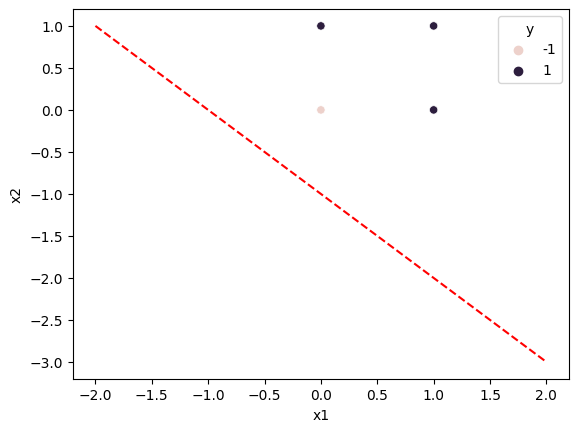

In [42]:
sns.scatterplot(data=data,
                x="x1",
                y="x2",
                hue="y")


x_support = np.linspace(-2, 2)
y_support = m*x_support + c

plt.plot(x_support, y_support, "--r")

plt.show()